# Intraday volume prediction model for stock

This project aims to build models for predicting the intraday trading volume of individual stocks (specifically focusing on AAPL). Predicting volume is important in trade execution as it helps estimate the market impact and determine whether the trade could be executed successfully.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import tensorflow as tf
import datetime

In [4]:
# load in data, and data processing
all_data = pd.read_csv('AAPL_mindata.csv', index_col=0, parse_dates=True)
all_data['date'] = all_data.index.date
all_data['time'] = all_data.index.time
all_data['avg_price'] = (all_data['high'] + all_data['low']) / 2
all_data['gkvol'] = np.sqrt((0.5 * (all_data.high - all_data.low) ** 2 - (2 * np.log(2) - 1) * (all_data.open - all_data.close) ** 2) / all_data.avg_price ** 2)
all_data['retvol'] = all_data.avg_price.pct_change() ** 2

In [5]:
# drop days which exist missing data within 9:30am to 16:00pm
clean_data = all_data.between_time('09:30', '16:00')
temp = clean_data.groupby(by='date').apply(lambda x: len(x))
incomplete_day = temp[temp != 391].index
clean_data = all_data[~all_data.date.isin(incomplete_day)]

In [6]:
clean_data

,open,high,low,close,volume,date,time,avg_price,gkvol,retvol
timestamp,,,,,,,,,,
2022-09-30 04:00:00,143.59,143.59,143.10,143.49,4060,2022-09-30,04:00:00,143.345,0.002378,NaN
2022-09-30 04:01:00,143.49,143.49,143.38,143.38,481,2022-09-30,04:01:00,143.435,0.000259,3.942030e-07
2022-09-30 04:02:00,143.22,143.22,143.22,143.22,107,2022-09-30,04:02:00,143.220,0.000000,2.246812e-06
2022-09-30 04:03:00,143.39,143.39,143.21,143.23,2811,2022-09-30,04:03:00,143.300,0.000554,3.120130e-07
2022-09-30 04:04:00,143.30,143.32,143.30,143.32,309,2022-09-30,04:04:00,143.310,0.000047,4.869761e-09
...,...,...,...,...,...,...,...,...,...,...
2023-09-29 19:45:00,171.20,171.20,171.20,171.20,800,2023-09-29,19:45:00,171.200,0.000000,8.529177e-10
2023-09-29 19:46:00,171.20,171.20,171.20,171.20,1917,2023-09-29,19:46:00,171.200,0.000000,0.000000e+00
2023-09-29 19:47:00,171.20,171.21,171.20,171.21,594,2023-09-29,19:47:00,171.205,0.000020,8.529675e-10


In [7]:
# split data into training set
train_test_ratio = 0.75
data = clean_data.between_time('09:00', '16:00')
unique_days = data.date.unique()
train_days = unique_days[: int(len(unique_days) * train_test_ratio)]
# test_days = unique_days[int(len(unique_days) * train_test_ratio) - rolling_regression_window:]
train_data = data[data['date'].isin(train_days)]
# test_data = data[data['date'].isin(test_days)]

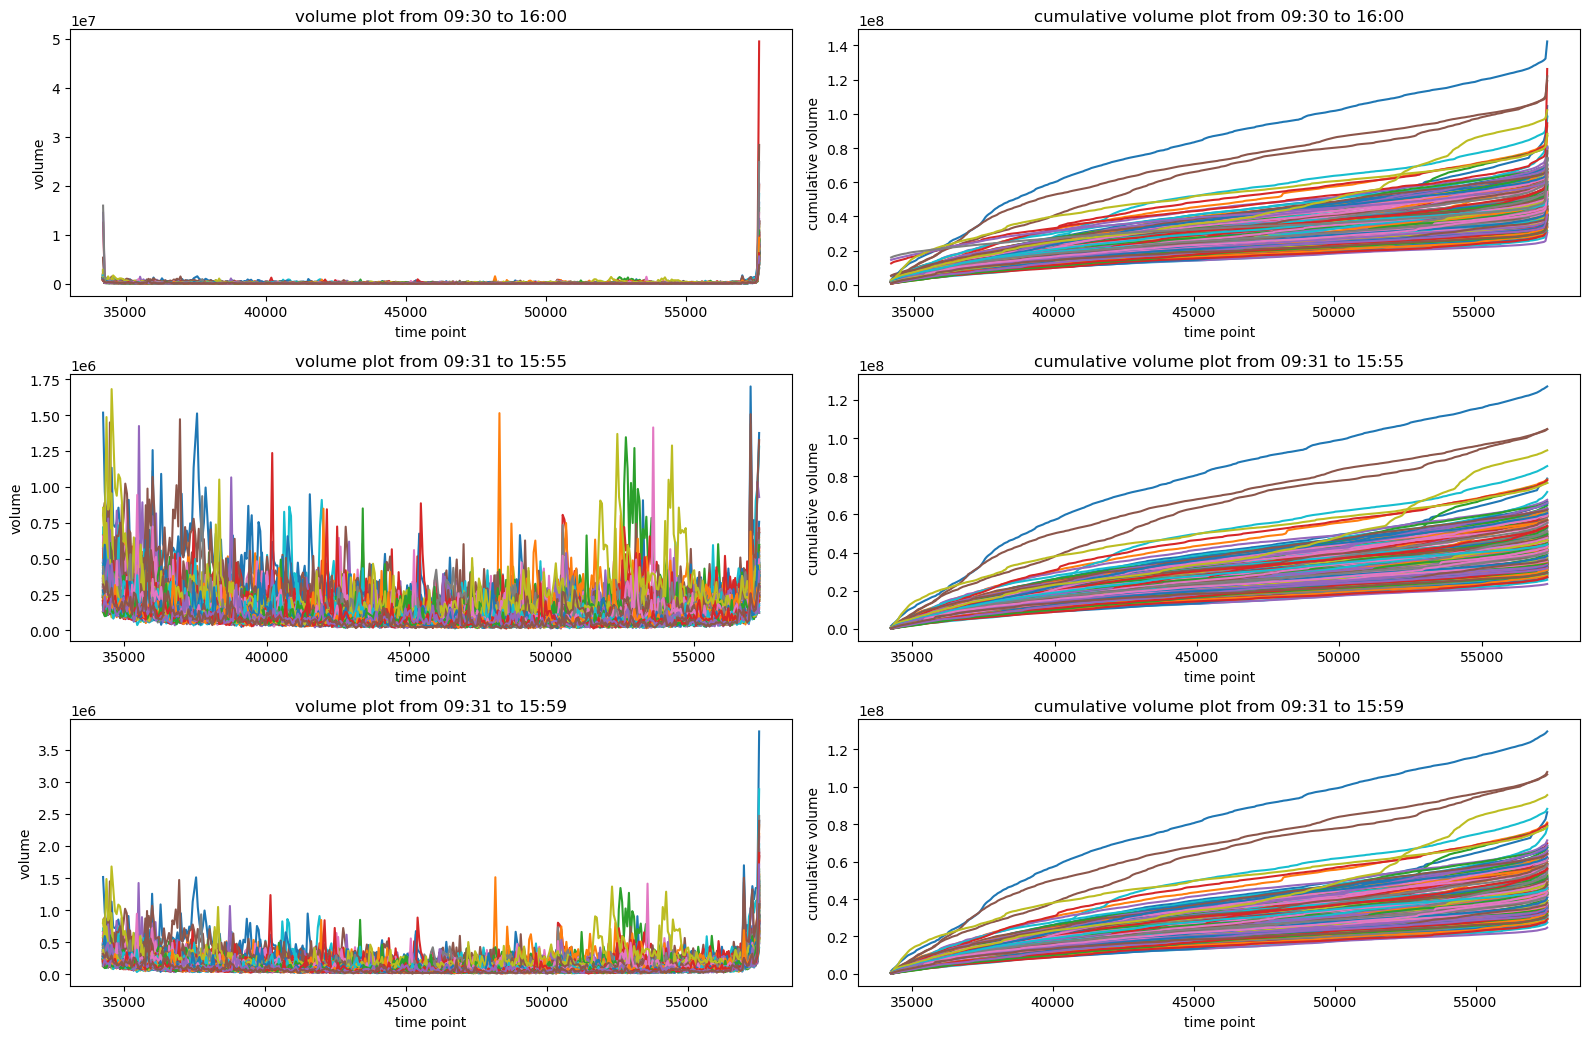

In [8]:
# visualise volume and cumulative volume curve
plot_range = [['09:30', '16:00'], ['09:31', '15:55'], ['09:31', '15:59']]
fig, axs = plt.subplots(len(plot_range), 2, figsize=(16, 3.5 * len(plot_range)))
for i, r in enumerate(plot_range):
    start_time, end_time = r[0], r[1]
    vol_data = train_data.between_time(start_time, end_time)[['volume', 'date', 'time']]
    for day in vol_data.date.unique():
        vol_day = vol_data[vol_data.date == day]
        vol = vol_day.volume
        cumVol = vol_day.volume.cumsum()
        x = [(t.hour * 3600) + (t.minute * 60) for t in vol_day.index.time]
        axs[i, 0].plot(x, vol)
        axs[i, 0].set_title(f'volume plot from {start_time} to {end_time}')
        axs[i, 0].set_xlabel('time point')
        axs[i, 0].set_ylabel('volume')
        axs[i, 1].plot(x, cumVol)
        axs[i, 1].set_title(f'cumulative volume plot from {start_time} to {end_time}')
        axs[i, 1].set_xlabel('time point')
        axs[i, 1].set_ylabel('cumulative volume')
plt.tight_layout()
plt.show()

## Prediction methodology
One possible prediction model is to fit a cubic polynomial to the cumulative volume curve, but the cubic curve usually performs poorly on both ends (i.e., on 09:30 and 16:00). In particular, the cubic polynomial always fails to capture the sharp increase in volume at market close. In order to explain for different behavior in volume for each period, 4 different models would be fitted into each period, and combine together at the end to formulate a final prediction.

First, a model using 'historic data', meaning that I use historic days' data to train the models, will be formulated. 

1. [Prediction of volume at 09:30](#1)
2. [Prediction of volume from 09:31 to 15:59](#2)
3. [Prediction of volume at 16:00](#3)

The `vol_historic` function combines the above 3 models together.

And finally, a real-time adjustment component would be added to the model using real-time data.

4. [Real time adjustment](#4)

The `intraday_volume_prediction` function combines all the above models together.

<a name="1"></a>
## 1 - Predicting trading volume at 09:30 using data from 09:00 to 09:29

It is reasonable to guess that the opening volume at 09:30 each day is correlated with the trading volume 30 minutes before the market open. For instance, if new information comes in before market open, there could already be higher trading volume, volume volatility, and return volatility before open auction.

Therefore, a regression model is built using volume mean, volume std, and return std from 09:00 to 09:29 to predict the volume at 09:30. On day $d$, the volume at 09:30 ${vol_d}$ is given by:

$$vol_d = \beta_0 + \beta_1 volMean_d + \beta_2 volStd_d + \beta_3 retStd_d$$

$n$ days rolling regression would be used to train the model to find out the value of parameters $\beta$. And to decide the value of $n$, some error metrics have been set up to decide which value would perform better in the training set:

Mean Absolute Error: $\frac{\sum_n |v_n - \hat{v_n}|}{N}$

Mean Absolute Percentage Error: $\frac{\sum_n |v_n - \hat{v_n}| / |v_n|}{N}$

Mean Squared Error: $\sqrt{\frac{\sum_n |v_n - \hat{v_n}|^2}{N}}$

In [9]:
# set up features for model training for volume at 09:30
xtrain_0900_0930 = pd.DataFrame()
ytrain_0900_0930 = pd.DataFrame()
train_data_0900_0929 = train_data.between_time('09:00', '09:29')
xtrain_0900_0930['volMean_0900_0929'] = train_data_0900_0929[['volume', 'date']].groupby(by='date').mean()
xtrain_0900_0930['volStd_0900_0929'] = train_data_0900_0929[['volume', 'date']].groupby(by='date').std()
xtrain_0900_0930['retVol_0900_0929'] = train_data_0900_0929[['retvol', 'date']].groupby(by='date').mean()
xtrain_0900_0930.reset_index(drop=True, inplace=True)
xtrain_0900_0930 = (xtrain_0900_0930 - xtrain_0900_0930.mean()) / xtrain_0900_0930.std()
ytrain_0900_0930['vol_0930'] = train_data[train_data.time == datetime.time(9, 30)].volume.values

In [10]:
xtrain_0900_0930.head()

,volMean_0900_0929,volStd_0900_0929,retVol_0900_0929
0,0.587037,0.032256,0.786156
1,0.732529,0.045497,-0.195924
2,0.075776,-0.048731,-0.710925
3,-0.254054,-0.330017,-0.296350
4,-0.636596,-0.474446,-0.087338


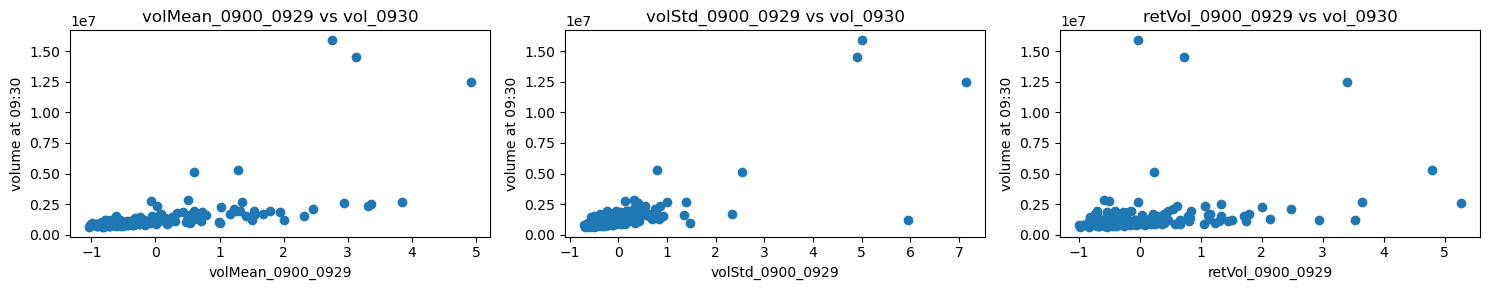

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for i, feature in enumerate(xtrain_0900_0930.columns):
    axs[i].scatter(xtrain_0900_0930[feature], ytrain_0900_0930)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('volume at 09:30')
    axs[i].set_title(f'{feature} vs vol_0930')
plt.tight_layout()
plt.show()

In [12]:
def compute_error(y, y_hat):
    if len(y) != len(y_hat):
        raise 'size of predicted values and actual values are not equal.'
    n = len(y)
    mae = np.sum(abs(y - y_hat)) / n
    mape = np.sum(abs(y_hat - y) / abs(y)) / n
    mse = np.sqrt(np.sum((y - y_hat) ** 2) / n)
    return pd.Series([mae, mape, mse], index=['mae', 'mape', 'mse'])

In [13]:
def regression_pred(x: np.array, y: pd.DataFrame, pred_x: np.array):
    X = np.array(x)
    X = sm.add_constant(X)
    Y = np.array(y)
    lm = sm.OLS(Y, X).fit()
    y_hat = lm.predict(pred_x)
    return y_hat

In [14]:
def regression_model_0930(x: pd.DataFrame, y: pd.DataFrame, rolling_window: int):
    y_hat = np.array([])
    for i in range(len(x) - rolling_window):
        prev_x = x[i: i + rolling_window]
        prev_y = y[i: i + rolling_window]
        tdy_x = x.iloc[i + rolling_window].values
        tdy_x = np.column_stack(tdy_x)
        tdy_x = sm.add_constant(tdy_x, has_constant='add')
        pred_y = regression_pred(x=prev_x, y=prev_y, pred_x=tdy_x)
        if pred_y < 0:
            pred_y = prev_y.mean()[0]
        y_hat = np.append(y_hat, pred_y)
    return y_hat

In [15]:
# compare different rolling windows
rolling_window = [10, 15, 20, 25, 30]
error_df = pd.DataFrame(index=['mae', 'mape', 'mse'])
for window in rolling_window:
    y_actual = ytrain_0900_0930[window:].values.reshape(-1, )
    y_hat = regression_model_0930(xtrain_0900_0930, ytrain_0900_0930, window)
    error = compute_error(y_actual, y_hat)
    error_df = pd.concat([error_df, error.to_frame(name=f'{window}')], axis=1)
    
print('error analysis with different rolling window: ')
error_df

error analysis with different rolling window: 


,10,15,20,25,30
mae,5.937810e+05,6.020688e+05,5.764059e+05,6.222868e+05,6.464405e+05
mape,3.298360e-01,3.253000e-01,3.668835e-01,3.763414e-01,3.935019e-01
mse,1.671268e+06,1.691002e+06,1.417546e+06,1.650603e+06,1.708221e+06


Based on the error analysis above, a rolling window of 20 days would be chosen for the prediction of volume at 09:30.

<a name="2"></a>
## 2 - Fitting cubic polynomials for the period 09:31 to 15:59

At time point $t$ during the period 09:31 to 15:59, the cumulative volume ${cumVol_t}$ is given by:

$$cumVol_t = \beta_0 + \beta_1 t + \beta_2 t^2 + \beta_3 t^3$$

In [16]:
train_data_0931_1559 = train_data.between_time('09:31', '15:59')[['time', 'date', 'volume']]
train_data_0931_1559['cumVol'] = train_data_0931_1559.groupby(by='date').volume.cumsum()
train_data_0931_1559['t'] = train_data_0931_1559.time.apply(lambda x: x.hour * 60 + x.minute - 9 * 60 - 30)
train_data_0931_1559['t2'] = train_data_0931_1559['t'] ** 2
train_data_0931_1559['t3'] = train_data_0931_1559['t'] ** 3
train_data_0931_1559.head()

,time,date,volume,cumVol,t,t2,t3
timestamp,,,,,,,
2022-09-30 09:31:00,09:31:00,2022-09-30,475394,475394,1,1,1
2022-09-30 09:32:00,09:32:00,2022-09-30,456415,931809,2,4,8
2022-09-30 09:33:00,09:33:00,2022-09-30,337576,1269385,3,9,27
2022-09-30 09:34:00,09:34:00,2022-09-30,426136,1695521,4,16,64
2022-09-30 09:35:00,09:35:00,2022-09-30,389357,2084878,5,25,125


In [17]:
def regression_model_0931_1559(df: pd.DataFrame, rolling_window: int):
    y_hat = np.array([])
    y_actual = np.array([])
    for i in range(len(df.date.unique()) - window):
        prev_date = df.date.unique()[i: i + window]
        prev_data = df[df.date.isin(prev_date)]
        prev_x = prev_data[['t', 't2', 't3']]
        prev_y = prev_data[['cumVol']]
        tdy_date = df.date.unique()[i + window]
        tdy_data = df[df.date == tdy_date]
        tdy_x = tdy_data[['t', 't2', 't3']]
        tdy_x = sm.add_constant(np.array(tdy_x))
        tdy_y = tdy_data[['cumVol']]
        pred_y = regression_pred(x=prev_x, y=prev_y, pred_x=tdy_x)
        y_hat = np.append(y_hat, pred_y)
        y_actual = np.append(y_actual, tdy_y.values)
    return y_actual, y_hat

In [18]:
rolling_window = [10, 15, 20, 25, 30]
error_df = pd.DataFrame(index=['mae', 'mape', 'mse'])
for window in rolling_window:
    y_actual, y_hat = regression_model_0931_1559(train_data_0931_1559, window)
    error = compute_error(y_actual, y_hat)
    error_df = pd.concat([error_df, error.to_frame(name=f'{window}')], axis=1)
    
print('error analysis with different rolling window: ')
error_df

error analysis with different rolling window: 


,10,15,20,25,30
mae,4.917148e+06,5.244380e+06,5.358192e+06,5.132614e+06,4.969768e+06
mape,2.107180e-01,2.279479e-01,2.343107e-01,2.351698e-01,2.351074e-01
mse,8.358529e+06,8.624895e+06,8.687790e+06,7.814789e+06,7.545919e+06


Based on the error analysis above, I would choose a rolling window of 30 days for the prediction of volume at 09:31 to 15:59.

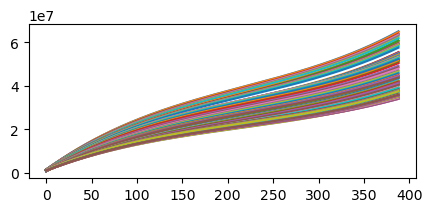

In [19]:
# plot of the predicted cumulative volume curve for the period 09:31 to 15:59
window = 30
plt.figure(figsize=(5, 2))
for i in range(len(train_data_0931_1559.date.unique()) - window):
    prev_date = train_data_0931_1559.date.unique()[i: i + window]
    prev_data = train_data_0931_1559[train_data_0931_1559.date.isin(prev_date)]
    prev_x = prev_data[['t', 't2', 't3']]
    prev_y = prev_data[['cumVol']]
    tdy_date = train_data_0931_1559.date.unique()[i + window]
    tdy_data = train_data_0931_1559[train_data_0931_1559.date == tdy_date]
    tdy_x = tdy_data[['t', 't2', 't3']]
    tdy_x = sm.add_constant(np.array(tdy_x))
    pred_y = regression_pred(x=prev_x, y=prev_y, pred_x=tdy_x)
    x = np.arange(0, len(pred_y))
    plt.plot(x, pred_y)
plt.show()

<a name="3"></a>
## 3 - Predicting trading volume at 16:00

Features that are used to predict the volume at market close are as follow:
- volume mean from 9:30 to 15:59 on that day
- volume std from 9:30 to 15:59 on that day
- return std from 9:30 to 15:59 on that day
- volume mean from 15:55 to 15:59 on that day
- volume std from 15:55 to 15:59 on that day
- return std from 15:55 to 15:59 on that day

A regression model with multiple rolling window, as well as a neural network model will be built to test out the performance.

In [20]:
# set up features for model training for volume at 16:00
xtrain_1600 = pd.DataFrame()
ytrain_1600 = pd.DataFrame()
train_data_0930_1559 = train_data.between_time('09:30', '15:59')
train_data_last4min = train_data.between_time('15:55', '15:59')
xtrain_1600['volMean_0930_1559'] = train_data_0930_1559[['volume', 'date']].groupby(by='date').mean()
xtrain_1600['volStd_0930_1559'] = train_data_0930_1559[['volume', 'date']].groupby(by='date').std()
xtrain_1600['retVol_0930_1559'] = train_data_0930_1559[['retvol', 'date']].groupby(by='date').mean()
xtrain_1600['volMean_1555_1559'] = train_data_last4min[['volume', 'date']].groupby(by='date').mean()
xtrain_1600['volStd_1555_1559'] = train_data_last4min[['volume', 'date']].groupby(by='date').std()
xtrain_1600['retVol_1555_1559'] = train_data_last4min[['retvol', 'date']].groupby(by='date').mean()
xtrain_1600.reset_index(drop=True, inplace=True)
xtrain_1600 = (xtrain_1600 - xtrain_1600.mean()) / xtrain_1600.std()
ytrain_1600['vol_1600'] = train_data[train_data.time == datetime.time(16, 0)].volume.values

# remove outlier
outlier_threshold = 2.5
ytrain_1600['vol_zScore'] = (ytrain_1600 - ytrain_1600.mean()) / ytrain_1600.std()
xtrain_1600 = xtrain_1600[abs(ytrain_1600.vol_zScore) < outlier_threshold]
ytrain_1600 = ytrain_1600[abs(ytrain_1600.vol_zScore) < outlier_threshold]
xtrain_1600.head()

,volMean_0930_1559,volStd_0930_1559,retVol_0930_1559,volMean_1555_1559,volStd_1555_1559,retVol_1555_1559
0,2.304578,1.612332,1.212070,6.451663,4.947770,1.735449
1,1.987546,0.598624,0.356513,0.713734,0.501927,-0.379679
2,0.828409,0.181510,-0.213506,0.702532,0.059865,-0.158736
3,0.791236,-0.017547,-0.073990,0.635637,0.733808,0.974802
4,0.118674,-0.255133,0.066552,0.358730,-0.162857,0.504475


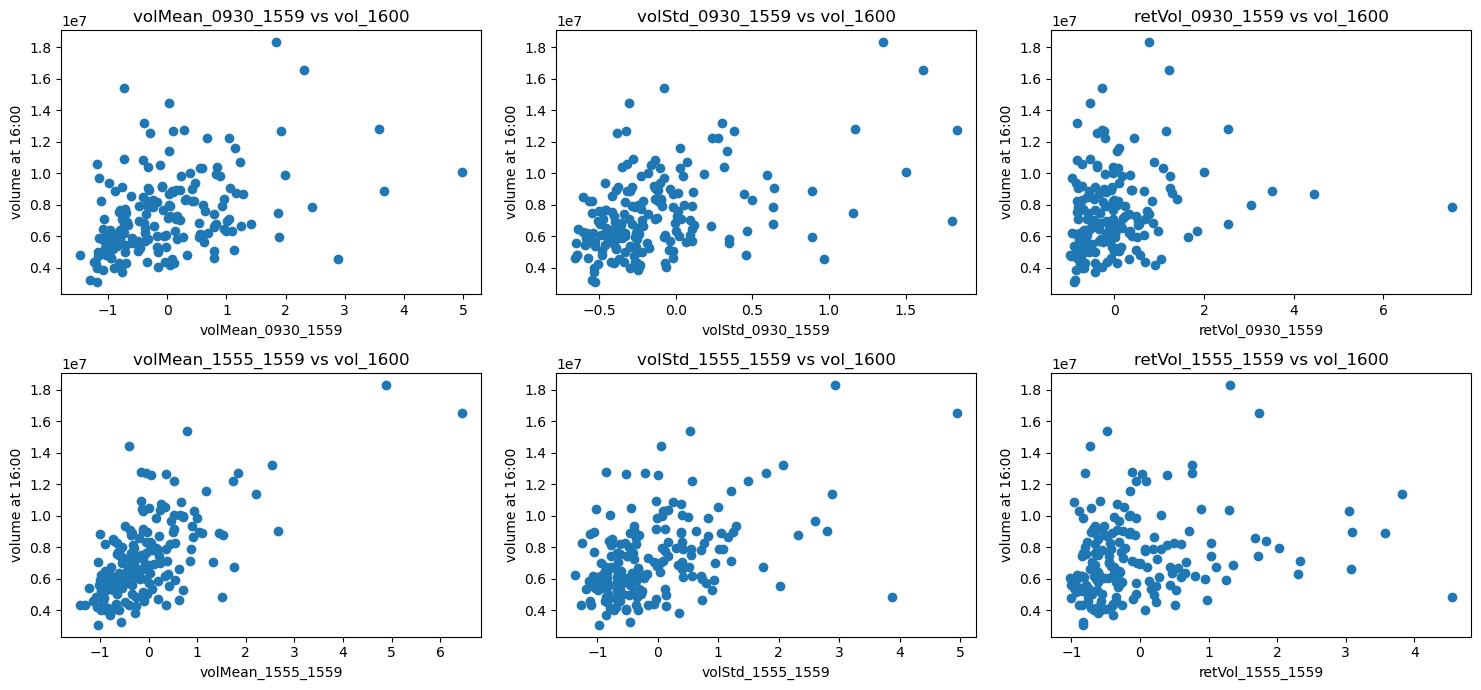

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
row = col = 0
for feature in xtrain_1600.columns:
    axs[row, col].scatter(xtrain_1600[feature], ytrain_1600['vol_1600'])
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('volume at 16:00')
    axs[row, col].set_title(f'{feature} vs vol_1600')
    col += 1
    if col == 3:
        row += 1
        col = 0
plt.tight_layout()
plt.show()

In [22]:
class NN_model:
    def __init__(self, x_train: pd.DataFrame, y_train: pd.DataFrame):
        self.x_train = x_train
        self.y_train = y_train
    
    def build_model(self):
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
        model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss="mae")
        return(model)
    
    def train(self, bs=32, ntry=10):
        model = self.build_model()
        model.fit(self.x_train, self.y_train, batch_size=bs, epochs=100, shuffle=True)
        self.best_model = model
        best_loss = model.evaluate(self.x_train[-50:], self.y_train[-50:])
        for _ in range(ntry):
            model = self.build_model()
            model.fit(self.x_train, self.y_train, batch_size=bs, epochs=100, shuffle=True)
            if model.evaluate(self.x_train, self.y_train) < best_loss:
                self.best_model = model
                best_loss = model.evaluate(self.x_train[-50:], self.y_train[-50:])
    
    def predict(self, x_test: pd.DataFrame):
        return self.best_model.predict(x_test)

In [23]:
# rolling regression model with different rolling windows
rolling_window = [10, 15, 20, 25, 30]
error_df = pd.DataFrame(index=['mae', 'mape', 'mse'])
for window in rolling_window:
    y_hat = np.array([])
    y_actual = ytrain_1600[['vol_1600']][window:].values.reshape(-1, )
    for i in range(len(xtrain_1600) - window):
        prev_x = xtrain_1600[i: i + window]
        prev_y = ytrain_1600[['vol_1600']][i: i + window]
        tdy_x = xtrain_1600.iloc[i + window].values
        tdy_x = np.column_stack(tdy_x)
        tdy_x = sm.add_constant(tdy_x, has_constant='add')
        pred_y = regression_pred(x=prev_x, y=prev_y, pred_x=tdy_x)
        y_hat = np.append(y_hat, pred_y)
    error = compute_error(y_actual, y_hat)
    error_df = pd.concat([error_df, error.to_frame(name=f'{window}')], axis=1)
    
# neural network model
nn_model_1600 = NN_model(xtrain_1600, ytrain_1600['vol_1600'])
nn_model_1600.train()
y_hat_nn = nn_model_1600.predict(xtrain_1600)
error = compute_error(np.array(ytrain_1600['vol_1600']), y_hat_nn.reshape(-1, ))
error_df = pd.concat([error_df, error.to_frame(name='nn model')], axis=1)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7310197.0000
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7472139.0000 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7187287.0000 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7316234.5000 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7369670.5000 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7325095.5000 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7257736.0000 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7337612.0000 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7155418.5000 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7414574.0000 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7482636.0000 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7306153.5000
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7121389.5000 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7022161.5000 
Ep

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1452406.8750 
Epoch 79/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1524052.2500 
Epoch 80/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1381473.7500 
Epoch 81/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1421313.1250 
Epoch 82/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1511173.3750 
Epoch 83/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1489597.8750 
Epoch 84/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1378654.8750 
Epoch 85/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1527594.5000 
Epoch 86/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1481157.8750 
Epoch 87/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1516169.6250 
Epoch 88/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1407593.2500 
Epoch 89/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1472713.2500 
Epoch 90/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1398295.8750 
Epoch 91/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1335466.2500 
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1667758.8750 
Epoch 55/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1561792.7500 
Epoch 56/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1494444.0000 
Epoch 57/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1479869.7500 
Epoch 58/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1497656.2500 
Epoch 59/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1574194.6250 
Epoch 60/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1607644.3750 
Epoch 61/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1428354.3750 
Epoch 62/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1513928.2500 
Epoch 63/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1526728.6250 
Epoch 64/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1518469.0000 
Epoch 65/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1357041.3750 
Epoch 66/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1497739.2500 
Epoch 67/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1501212.5000 
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2793027.0000 
Epoch 31/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2697706.0000 
Epoch 32/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2791945.7500 
Epoch 33/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2617238.2500 
Epoch 34/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2470343.0000 
Epoch 35/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2386133.0000 
Epoch 36/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2314350.7500 
Epoch 37/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2154989.5000 
Epoch 38/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2154197.5000 
Epoch 39/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2073324.5000 
Epoch 40/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1907202.3750 
Epoch 41/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1965303.1250 
Epoch 42/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1820997.8750 
Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1787641.1250
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7174494.0000 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7356008.5000 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7393007.5000 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7108669.0000 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7187980.0000 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7462776.0000 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7222003.0000 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7100685.5000 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7038025.5000 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6857118.0000 
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6806552.0000 
Epoch 17/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6627840.0000 
Epoch 18/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6299116.0000 
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5749045.5000 
Epoch 20

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1428456.7500 
Epoch 84/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1479035.5000 
Epoch 85/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1429868.2500 
Epoch 86/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1534122.2500 
Epoch 87/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1361028.0000 
Epoch 88/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1363137.7500 
Epoch 89/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1437986.8750 
Epoch 90/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1542463.6250 
Epoch 91/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1459422.0000 
Epoch 92/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1628278.7500 
Epoch 93/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1441104.2500 
Epoch 94/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1476047.0000 
Epoch 95/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1441518.6250 
Epoch 96/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1476101.0000 
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1449408.3750 
Epoch 60/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1606249.2500 
Epoch 61/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1514287.8750 
Epoch 62/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1466054.7500 
Epoch 63/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1609875.6250 
Epoch 64/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1513363.8750 
Epoch 65/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1490875.7500 
Epoch 66/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1469910.6250 
Epoch 67/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1491075.0000 
Epoch 68/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1431574.2500 
Epoch 69/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1578479.8750 
Epoch 70/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1544581.2500 
Epoch 71/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1504033.3750 
Epoch 72/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1400655.2500 
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2353522.7500 
Epoch 36/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2497199.2500 
Epoch 37/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2323988.2500 
Epoch 38/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2146471.7500 
Epoch 39/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2200332.2500 
Epoch 40/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2152671.0000 
Epoch 41/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2050272.8750 
Epoch 42/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1941900.0000 
Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1863178.1250 
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1947434.3750 
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1865941.8750 
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1734702.7500 
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1762483.6250 
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1666123.8750 
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7511936.0000 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7580789.5000 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7246412.0000 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7467246.0000 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7479880.0000 
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7531231.5000 
Epoch 17/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7180493.5000 
Epoch 18/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7399885.0000 
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7440593.5000 
Epoch 20/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7508218.5000 
Epoch 21/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7266273.5000 
Epoch 22/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7453337.0000 
Epoch 23/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7479871.0000 
Epoch 24/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7267404.5000 
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7439558.0000 
Epoch 89/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7462225.5000 
Epoch 90/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7431768.5000 
Epoch 91/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7456635.5000 
Epoch 92/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7321347.5000 
Epoch 93/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7243696.0000 
Epoch 94/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7431776.5000 
Epoch 95/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7261077.5000 
Epoch 96/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7378384.5000 
Epoch 97/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7404312.5000 
Epoch 98/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7267058.5000 
Epoch 99/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7158502.5000 
Epoch 100/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7453706.5000 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7811015.5000 
Epoch 1/100
6/6 ━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1471789.0000 
Epoch 65/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1424892.1250 
Epoch 66/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1550050.7500 
Epoch 67/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1505774.7500 
Epoch 68/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1509173.6250 
Epoch 69/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1470225.0000 
Epoch 70/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1485789.3750 
Epoch 71/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1516553.1250 
Epoch 72/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1488385.1250 
Epoch 73/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1548143.0000 
Epoch 74/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1466974.5000 
Epoch 75/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1566578.0000 
Epoch 76/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1370739.2500 
Epoch 77/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1477305.2500 
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2364517.0000 
Epoch 41/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2287516.5000 
Epoch 42/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2245750.0000 
Epoch 43/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2133399.0000 
Epoch 44/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2245495.7500 
Epoch 45/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1917230.8750 
Epoch 46/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2110275.5000 
Epoch 47/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2091882.3750 
Epoch 48/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1945371.6250 
Epoch 49/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1714052.6250 
Epoch 50/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1811947.3750 
Epoch 51/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1803893.0000 
Epoch 52/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1762242.1250 
Epoch 53/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1805302.1250 
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6658897.5000 
Epoch 17/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6119745.0000 
Epoch 18/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5767957.5000 
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5222587.0000 
Epoch 20/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4835190.5000 
Epoch 21/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4187128.5000 
Epoch 22/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3620303.0000 
Epoch 23/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3646838.2500 
Epoch 24/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3429747.5000 
Epoch 25/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3264465.2500 
Epoch 26/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3137824.7500 
Epoch 27/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2984241.5000 
Epoch 28/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2975938.5000 
Epoch 29/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2841674.5000 
Epoch

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1437291.3750 
Epoch 94/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1446619.7500 
Epoch 95/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1408497.0000 
Epoch 96/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1449127.3750 
Epoch 97/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1373386.8750 
Epoch 98/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1401611.7500 
Epoch 99/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1399616.3750 
Epoch 100/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1316688.7500 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1528828.8750 
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7166739.5000  
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7165207.5000 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7295533.5000 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7536116.0000 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7563465.0000 
Epoch 6/100
6/6 ━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1505703.0000 
Epoch 70/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1504875.8750 
Epoch 71/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1624747.3750 
Epoch 72/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1454648.0000 
Epoch 73/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1467967.3750 
Epoch 74/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1591330.7500 
Epoch 75/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1532139.5000 
Epoch 76/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1366883.0000 
Epoch 77/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1537735.2500 
Epoch 78/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1486934.5000 
Epoch 79/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1440857.0000 
Epoch 80/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1387302.6250 
Epoch 81/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1496733.8750 
Epoch 82/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1523847.3750 
Epoch

In [24]:
print('error analysis with different models: ')
error_df

error analysis with different models: 


,10,15,20,25,30,nn model
mae,3.251333e+06,2.138633e+06,1.977607e+06,1.757158e+06,1.754372e+06,1.440218e+06
mape,4.603045e-01,3.078869e-01,2.826021e-01,2.536007e-01,2.574292e-01,2.068600e-01
mse,5.322223e+06,3.007193e+06,2.633268e+06,2.339940e+06,2.350671e+06,1.960308e+06


Based on the error analysis above, using a neural network model for the prediction of volume at 16:00 appears to minimize the loss.

In [25]:
# overall model to predict volume using historic data
def vol_historic(data: pd.DataFrame, nn_model_1600: NN_model, window_0930: int = 20, window_0931_1559: int = 30):
    trading_vol_df = pd.DataFrame(columns=['pred_trading_vol', 'actual_trading_vol'])
    max_window = max(window_0930, window_0931_1559)
    
    # data processing for prediction at 16:00
    x_1600 = pd.DataFrame()
    data_0930_1559 = data.between_time('09:30', '15:59')
    data_last4min = data.between_time('15:55', '15:59')
    x_1600['volMean_0930_1559'] = data_0930_1559[['volume', 'date']].groupby(by='date').mean()
    x_1600['volStd_0930_1559'] = data_0930_1559[['volume', 'date']].groupby(by='date').std()
    x_1600['retVol_0930_1559'] = data_0930_1559[['retvol', 'date']].groupby(by='date').mean()
    x_1600['volMean_1555_1559'] = data_last4min[['volume', 'date']].groupby(by='date').mean()
    x_1600['volStd_1555_1559'] = data_last4min[['volume', 'date']].groupby(by='date').std()
    x_1600['retVol_1555_1559'] = data_last4min[['retvol', 'date']].groupby(by='date').mean()
    x_1600 = (x_1600 - x_1600.mean()) / x_1600.std()
    
    for i in range(max_window, len(data.date.unique())):
        pred_trading_vol = np.array([])
        tdy_date = data.date.unique()[i]
        
        # volume prediction at 09:30
        previous_date_0930 = data.date.unique()[i - window_0930: i + 1]
        previous_xdata_0930 = data[data.date.isin(previous_date_0930)].between_time('09:00', '09:29')
        previous_ydata_0930 = data[data.date.isin(previous_date_0930)].between_time('09:30', '09:30')
        x_0930 = pd.DataFrame()
        x_0930['volMean_0900_0929'] = previous_xdata_0930[['volume', 'date']].groupby(by='date').mean()
        x_0930['volStd_0900_0929'] = previous_xdata_0930[['volume', 'date']].groupby(by='date').std()
        x_0930['retVol_0900_0929'] = previous_xdata_0930[['retvol', 'date']].groupby(by='date').mean()
        x_0930.reset_index(drop=True, inplace=True)
        x_0930 = (x_0930 - x_0930.mean()) / x_0930.std()
        y_0930 = previous_ydata_0930.volume.values[: -1]
        x_tdy = np.column_stack(x_0930.iloc[-1])
        x_tdy = sm.add_constant(x_tdy, has_constant='add')
        pred_vol_0930 = regression_pred(x=x_0930.iloc[:-1], y=y_0930, pred_x=x_tdy)[0]
        if pred_vol_0930 < 0:
            pred_vol_0930 = y_0930.mean()
        pred_trading_vol = np.append(pred_trading_vol, pred_vol_0930)
        
        # volume prediction at 09:31 to 15:59
        previous_date_0931_1559 = data.date.unique()[i - window_0931_1559: i + 1]
        previous_data_0931_1559 = data[data.date.isin(previous_date_0931_1559)].between_time('09:31', '15:59')[['time', 'date', 'volume']]
        previous_data_0931_1559['cumVol'] = previous_data_0931_1559.groupby(by='date').volume.cumsum()
        previous_data_0931_1559['t'] = previous_data_0931_1559.time.apply(lambda x: x.hour * 60 + x.minute - 9 * 60 - 30)
        previous_data_0931_1559['t2'] = previous_data_0931_1559['t'] ** 2
        previous_data_0931_1559['t3'] = previous_data_0931_1559['t'] ** 3
        pred_cumVol_0931_1559 = regression_model_0931_1559(previous_data_0931_1559, window)[1]
        pred_vol_0931_1559 = np.diff(pred_cumVol_0931_1559)
        pred_vol_0931_1559 = np.insert(pred_vol_0931_1559, 0, pred_cumVol_0931_1559[0])
        pred_vol_0931_1559 = pred_vol_0931_1559.clip(0, None)
        pred_trading_vol = np.append(pred_trading_vol, pred_vol_0931_1559)
        
        # volume prediction at 16:00
        x_tdy = x_1600[x_1600.index == tdy_date]
        pred_vol_1600 = nn_model_1600.predict(x_tdy)[0][0]
        pred_trading_vol = np.append(pred_trading_vol, pred_vol_1600)
        
        idx = data[data.date == tdy_date].between_time('09:30', '16:00').index
        actual_trading_vol = data[data.date == tdy_date].between_time('09:30', '16:00').volume.values
        tdy_vol = pd.DataFrame({
            'pred_trading_vol': pred_trading_vol,
            'actual_trading_vol': actual_trading_vol
        }, index=idx)
        trading_vol_df = pd.concat([trading_vol_df, tdy_vol])
        
    return trading_vol_df

In [26]:
pred_vol_train_set = vol_historic(train_data, nn_model_1600)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [27]:
pred_vol_train_set

,pred_trading_vol,actual_trading_vol
2022-11-11 09:30:00,2.477120e+06,1543981
2022-11-11 09:31:00,1.467910e+06,363246
2022-11-11 09:32:00,3.040016e+05,487742
2022-11-11 09:33:00,3.022260e+05,602612
2022-11-11 09:34:00,3.004586e+05,386117
...,...,...
2023-06-29 15:56:00,1.239784e+05,165506
2023-06-29 15:57:00,1.247289e+05,218179
2023-06-29 15:58:00,1.254840e+05,367488
2023-06-29 15:59:00,1.262434e+05,1093377


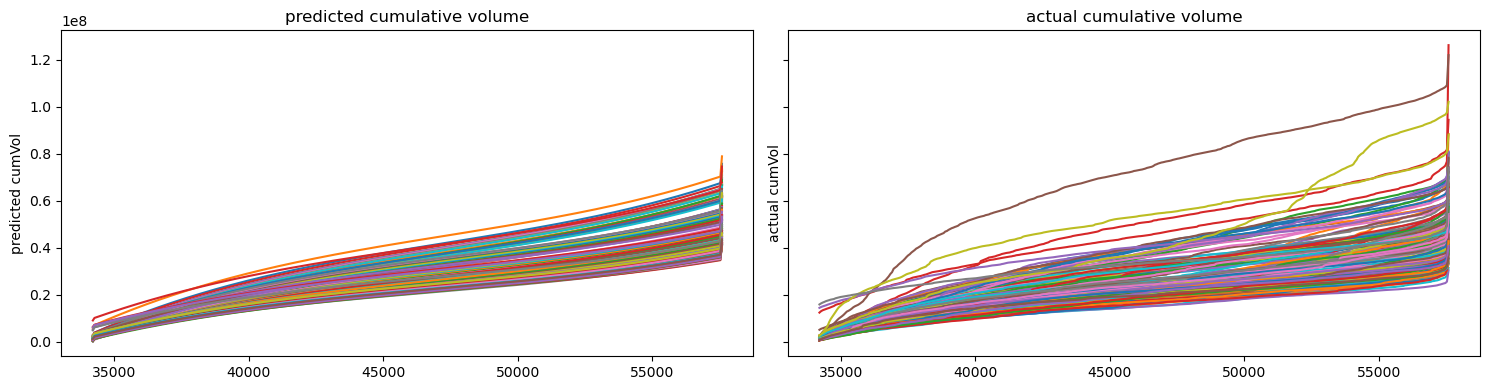

In [28]:
# plotting of cumulative volume for trained dataset
fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
pred_vol_train_set['date'] = pred_vol_train_set.index.date
for date in pred_vol_train_set.date.unique():
    pred_vol = pred_vol_train_set[pred_vol_train_set.date == date]
    x = [(t.hour * 3600) + (t.minute * 60) for t in pred_vol.index.time]
    axs[0].plot(x, pred_vol['pred_trading_vol'].cumsum())
    axs[1].plot(x, pred_vol['actual_trading_vol'].cumsum())
    
axs[0].set_ylabel('predicted cumVol')
axs[0].set_title('predicted cumulative volume')
axs[1].set_ylabel('actual cumVol')
axs[1].set_title('actual cumulative volume')
plt.tight_layout()
plt.show()

<a name="4"></a>
## 4 - Real time adjustment

A real-time component will be added into the model to further adjust the historic-estimated cumulative volume curve when the real-time volume deviates from the one we estimated. A major adjustment would be made for the period 09:32 to 15:59, where the original cubic model is given by $cumVol_t = \beta_0 + \beta_1 t + \beta_2 t^2 + \beta_3 t^3 + \epsilon_t$, and I further adjust the model by modelling $\epsilon_t$, and fit an ARIMA(1, 1, 0) and regression model to the residual $\epsilon_t$.

The model is given as:
$$\epsilon_t - \epsilon_{t-1} = \beta_0 + \beta_1 (\epsilon_{t-1} - \epsilon_{t-2}) + \beta_2 {GKVol_{t-1}} + \beta_3 {RetVol_{t-1}}$$

where ${GKVol_t}$ = $\sqrt{\frac{0.5(H_t-L_t)^2-(2log2-1)(O_t-C_t)^2}{M_t ^ 2}}$, ${RetVol_t}$ = $\big(\frac{M_t-M_{t-1}}{M_{t-1}}\big)^2$

so we could update the residual using real-time data by:
$$\epsilon_{t+1} = \epsilon_t + \beta_0 + \beta_1 (\epsilon_t - \epsilon_{t-1}) + \beta_2 {GKVol_t} + \beta_3 {RetVol_t}$$

In [29]:
def data_adjustment_rt(pred_vol_hist: pd.DataFrame, data: pd.DataFrame):
    pred_vol_hist[['pred_trading_vol', 'actual_trading_vol']] = pred_vol_hist[['pred_trading_vol', 'actual_trading_vol']].astype(float)
    pred_vol_hist[['pred_cumVol', 'actual_cumVol']] = pred_vol_hist.groupby(by='date').cumsum()
    pred_vol_hist['cumVol_residual_t'] = pred_vol_hist['actual_cumVol'] - pred_vol_hist['pred_cumVol']
    pred_vol_hist['delta_cumVol_residual_t'] = pred_vol_hist.groupby(by='date')['cumVol_residual_t'].diff()
    pred_vol_hist['delta_cumVol_residual_tp1'] = pred_vol_hist['delta_cumVol_residual_t'].shift(-1)
    pred_vol_hist = pd.merge(pred_vol_hist, data[['gkvol', 'retvol']], left_index=True, right_index=True, how='left')
    return pred_vol_hist

In [30]:
def rt_adjustment(pred_vol_hist: pd.DataFrame, data: pd.DataFrame, window: int):
    df = data_adjustment_rt(pred_vol_hist.copy(), data)
    df = df.between_time('09:32', '15:59')
    all_dates = df.date.unique()
    residual_df = pd.DataFrame()
    for i in range(len(all_dates) - window):
        dates = all_dates[i: i + window + 1]
        temp_df = df[df.date.isin(dates)]
        x_df = temp_df[['delta_cumVol_residual_t', 'gkvol', 'retvol']]
        x_df = (x_df - x_df.mean()) / x_df.std()
        x_df['date'] = x_df.index.date
        prev_dates = all_dates[i: i + window]
        tdy_date = all_dates[i + window]
        prev_x = x_df[x_df.date.isin(prev_dates)][['delta_cumVol_residual_t', 'gkvol', 'retvol']]
        prev_x = sm.add_constant(np.array(prev_x))
        prev_y = df[df.date.isin(prev_dates)]['delta_cumVol_residual_tp1']
        prev_y = np.array(prev_y)
        tdy_x = x_df[x_df.date.isin([tdy_date])][['delta_cumVol_residual_t', 'gkvol', 'retvol']]
        pred_x = sm.add_constant(np.array(tdy_x))
        tdy_residual = df[df.date.isin([tdy_date])][['delta_cumVol_residual_tp1']]
        lm = sm.OLS(prev_y, prev_x).fit()
        pred = lm.predict(pred_x)
        tdy_residual['pred_delta_cumVol_residual_tp1'] = pred
        residual_df = pd.concat([residual_df, tdy_residual])
    return residual_df

In [31]:
rolling_window = [10, 15, 20, 25, 30]
error_df = pd.DataFrame(index=['mae', 'mape', 'mse'])
for window in rolling_window:
    residual_df = rt_adjustment(pred_vol_train_set.copy(), train_data, window)
    error = compute_error(residual_df['delta_cumVol_residual_tp1'], residual_df['pred_delta_cumVol_residual_tp1'])
    error_df = pd.concat([error_df, error.to_frame(name=f'{window}')], axis=1)
    
print('error analysis with different rolling window: ')
error_df

error analysis with different rolling window: 


,10,15,20,25,30
mae,50814.461569,49476.693812,48228.055036,45942.194588,43993.703102
mape,4.407083,4.141649,4.094857,4.052347,3.876599
mse,241436.293193,238170.907145,241088.549065,178190.184538,177465.765684


Based on the error analysis above, a rolling window of 30 days would be chosen for the training of real-time adjustment part.

In [32]:
# final prediction by combining all the models together
window_rt = 30
residual_df = rt_adjustment(pred_vol_train_set.copy(), train_data, window_rt)
res_df = pred_vol_train_set.copy()
res_df = pd.merge(res_df, residual_df, left_index=True, right_index=True, how='left')
res_df['pred_trading_vol'] = res_df['pred_trading_vol'].astype(float)
res_df['actual_trading_vol'] = res_df['actual_trading_vol'].astype(float)
res_df['pred_trading_cumVol'] = res_df.groupby(by='date')['pred_trading_vol'].cumsum()
res_df['actual_trading_cumVol'] = res_df.groupby(by='date')['actual_trading_vol'].cumsum()
res_df['residual'] = res_df['actual_trading_cumVol'] - res_df['pred_trading_cumVol']
res_df['cumVol_pred'] = res_df['pred_trading_cumVol'] + res_df['pred_delta_cumVol_residual_tp1'] + res_df['residual']
res_df['final_vol_pred'] = res_df.groupby(by='date')['cumVol_pred'].diff()
res_df['final_vol_pred'] = res_df.apply(lambda row: row['pred_trading_vol'] if pd.isnull(row['final_vol_pred']) else row['final_vol_pred'], axis=1)
res_df['final_vol_pred'] = res_df['final_vol_pred'].clip(0, None)
res_df['final_cumVol_pred'] = res_df.groupby(by='date')['final_vol_pred'].cumsum()
res_df.head()

,pred_trading_vol,actual_trading_vol,date,delta_cumVol_residual_tp1,pred_delta_cumVol_residual_tp1,pred_trading_cumVol,actual_trading_cumVol,residual,cumVol_pred,final_vol_pred,final_cumVol_pred
2022-11-11 09:30:00,2.477120e+06,1543981.0,2022-11-11,NaN,NaN,2.477120e+06,1543981.0,-9.331386e+05,NaN,2.477120e+06,2.477120e+06
2022-11-11 09:31:00,1.467910e+06,363246.0,2022-11-11,NaN,NaN,3.945030e+06,1907227.0,-2.037803e+06,NaN,1.467910e+06,3.945030e+06
2022-11-11 09:32:00,3.040016e+05,487742.0,2022-11-11,NaN,NaN,4.249031e+06,2394969.0,-1.854062e+06,NaN,3.040016e+05,4.249031e+06
2022-11-11 09:33:00,3.022260e+05,602612.0,2022-11-11,NaN,NaN,4.551257e+06,2997581.0,-1.553676e+06,NaN,3.022260e+05,4.551257e+06
2022-11-11 09:34:00,3.004586e+05,386117.0,2022-11-11,NaN,NaN,4.851716e+06,3383698.0,-1.468018e+06,NaN,3.004586e+05,4.851716e+06


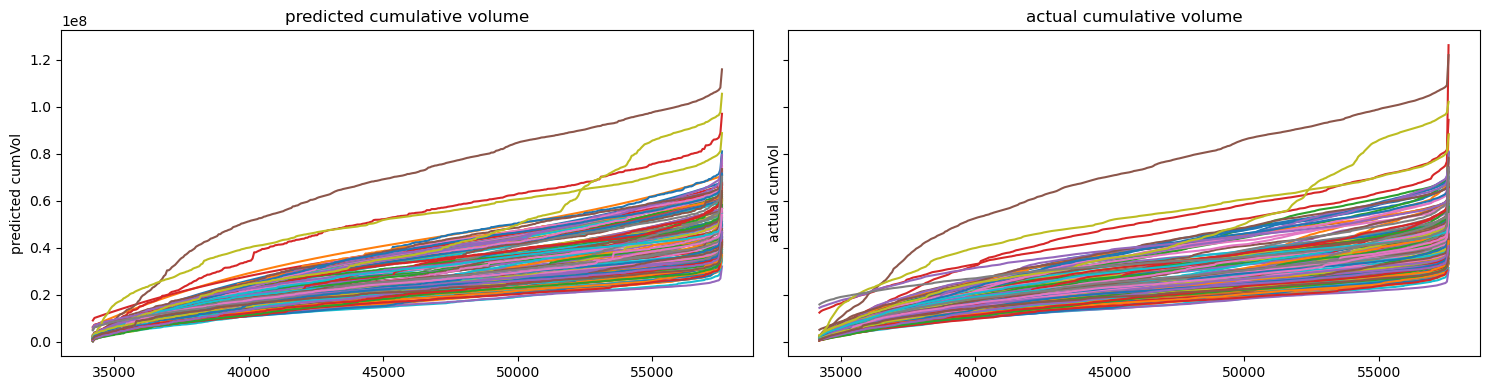

In [33]:
# plotting of cumulative volume for trained dataset
fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
res_df['date'] = res_df.index.date
for date in res_df.date.unique():
    pred_vol = res_df[res_df.date == date]
    x = [(t.hour * 3600) + (t.minute * 60) for t in pred_vol.index.time]
    axs[0].plot(x, pred_vol['final_cumVol_pred'])
    axs[1].plot(x, pred_vol['actual_trading_cumVol'])
    
axs[0].set_ylabel('predicted cumVol')
axs[0].set_title('predicted cumulative volume')
axs[1].set_ylabel('actual cumVol')
axs[1].set_title('actual cumulative volume')
plt.tight_layout()
plt.show()

In [34]:
# entire model
def intraday_volume_prediction(data: pd.DataFrame, nn_model_1600: NN_model, window_0930: int = 20, window_0931_1559: int = 30, window_rt_adjust: int = 30):
    # historic model
    pred_hist_vol = vol_historic(data, nn_model_1600)
    pred_hist_vol['date'] = pred_hist_vol.index.date
    
    # real time adjustment
    residual_df = rt_adjustment(pred_hist_vol.copy(), data, window_rt_adjust)
    res_df = pred_hist_vol.copy()
    res_df = pd.merge(res_df, residual_df, left_index=True, right_index=True, how='left')
    res_df['pred_trading_vol'] = res_df['pred_trading_vol'].astype(float)
    res_df['actual_trading_vol'] = res_df['actual_trading_vol'].astype(float)
    res_df['pred_trading_cumVol'] = res_df.groupby(by='date')['pred_trading_vol'].cumsum()
    res_df['actual_trading_cumVol'] = res_df.groupby(by='date')['actual_trading_vol'].cumsum()
    res_df['residual'] = res_df['actual_trading_cumVol'] - res_df['pred_trading_cumVol']
    res_df['cumVol_pred'] = res_df['pred_trading_cumVol'] + res_df['pred_delta_cumVol_residual_tp1'] + res_df['residual']
    res_df['final_vol_pred'] = res_df.groupby(by='date')['cumVol_pred'].diff()
    res_df['final_vol_pred'] = res_df.apply(lambda row: row['pred_trading_vol'] if pd.isnull(row['final_vol_pred']) else row['final_vol_pred'], axis=1)
    res_df['final_vol_pred'] = res_df['final_vol_pred'].clip(0, None)
    res_df['final_cumVol_pred'] = res_df.groupby(by='date')['final_vol_pred'].cumsum()
    res_df = res_df[['final_vol_pred', 'actual_trading_vol']]
    res_df['date'] = res_df.index.date
    res_dates = res_df.date.unique()[window_rt_adjust:]
    res_df = res_df[res_df.date.isin(res_dates)]
    return res_df

# Performance analysis
The above model would be applied here for both the train and test set, and some error and performance analysis would be done.

In [35]:
# split for test dataset
max_window = 30
test_days = unique_days[int(len(unique_days) * train_test_ratio) - max_window:]
test_data = data[data['date'].isin(test_days)]

In [36]:
train_res = intraday_volume_prediction(train_data, nn_model_1600)
test_res = intraday_volume_prediction(test_data, nn_model_1600)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

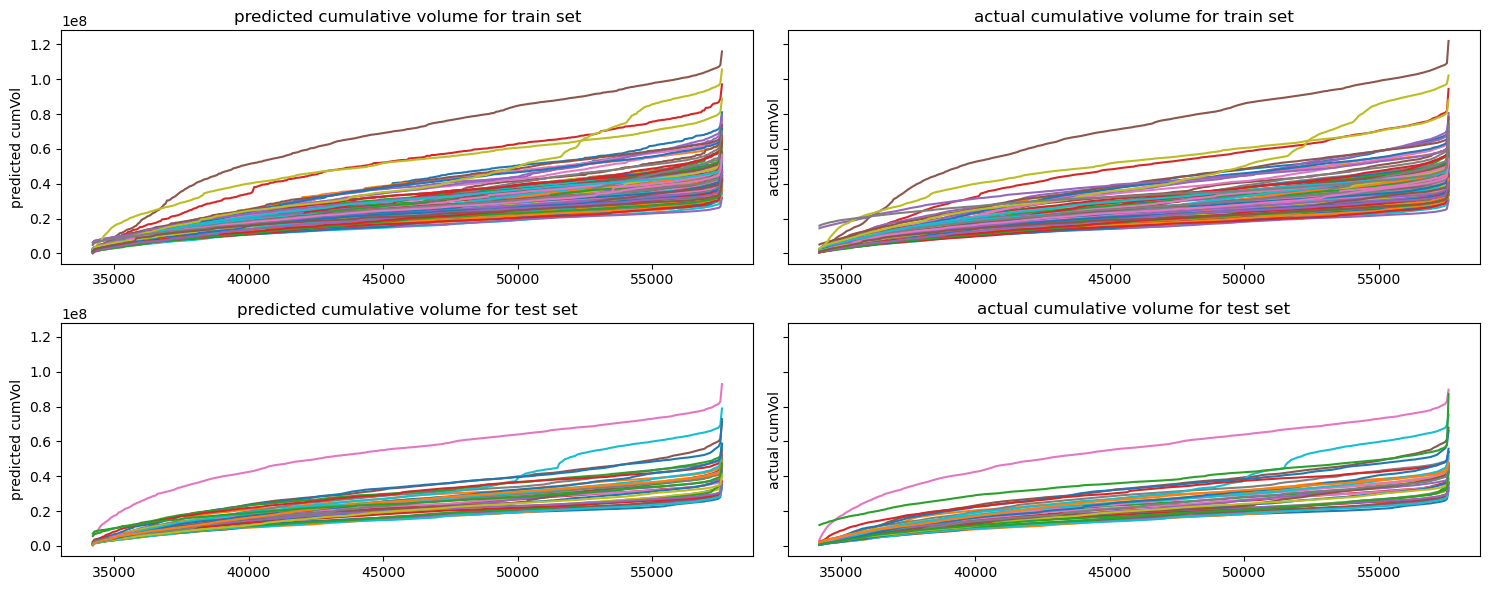

In [37]:
# plotting of cumulative volume
fig, axs = plt.subplots(2, 2, figsize=(15, 6), sharey=True)
for date in train_res.date.unique():
    pred_vol = train_res[train_res.date == date]
    x = [(t.hour * 3600) + (t.minute * 60) for t in pred_vol.index.time]
    axs[0, 0].plot(x, pred_vol['final_vol_pred'].cumsum())
    axs[0, 1].plot(x, pred_vol['actual_trading_vol'].cumsum())
for date in test_res.date.unique():
    pred_vol = test_res[test_res.date == date]
    x = [(t.hour * 3600) + (t.minute * 60) for t in pred_vol.index.time]
    axs[1, 0].plot(x, pred_vol['final_vol_pred'].cumsum())
    axs[1, 1].plot(x, pred_vol['actual_trading_vol'].cumsum())
    diff = (pred_vol['actual_trading_vol'] - pred_vol['final_vol_pred']).sum()
axs[0, 0].set_ylabel('predicted cumVol')
axs[0, 0].set_title('predicted cumulative volume for train set')
axs[0, 1].set_ylabel('actual cumVol')
axs[0, 1].set_title('actual cumulative volume for train set')
axs[1, 0].set_ylabel('predicted cumVol')
axs[1, 0].set_title('predicted cumulative volume for test set')
axs[1, 1].set_ylabel('actual cumVol')
axs[1, 1].set_title('actual cumulative volume for test set')
plt.tight_layout()
plt.show()

In [38]:
def performance_analysis(res: pd.DataFrame):
    res['time'] = res.index.time
    res['error'] = res.actual_trading_vol - res.final_vol_pred
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    
    # performance by each minute of a day
    volume_mae_by_time = res.groupby(by='time').apply(lambda x: abs(x.error).sum() / len(x))
    volume_mse_by_time = res.groupby(by='time').apply(lambda x: (x.error ** 2).sum() / len(x))
    time_seconds = [datetime.datetime.combine(datetime.datetime.today(), t) for t in volume_mae_by_time.index]
    axs[0, 0].plot(time_seconds, volume_mae_by_time.values)
    axs[0, 1].plot(time_seconds, volume_mse_by_time.values)
    axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axs[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    axs[0, 0].set_xlabel('time')
    axs[0, 0].set_ylabel('mae')
    axs[0, 0].set_title('mae by time')
    axs[0, 1].set_xlabel('time')
    axs[0, 1].set_ylabel('mse')
    axs[0, 1].set_title('mse by time')
    
    # performance by day
    volume_mae_by_day = res.groupby(by='date').apply(lambda x: abs(x.error).sum() / len(x))
    volume_mse_by_day = res.groupby(by='date').apply(lambda x: (x.error ** 2).sum() / len(x))
    axs[1, 0].plot(volume_mae_by_day.index, volume_mae_by_day.values)
    axs[1, 1].plot(volume_mse_by_day.index, volume_mse_by_day.values)
    axs[1, 0].set_xlabel('date')
    axs[1, 0].set_ylabel('mae')
    axs[1, 0].set_title('mae by date')
    axs[1, 1].set_xlabel('date')
    axs[1, 1].set_ylabel('mse')
    axs[1, 1].set_title('mse by date')
    
    plt.tight_layout()
    plt.show()

plot for train set: 


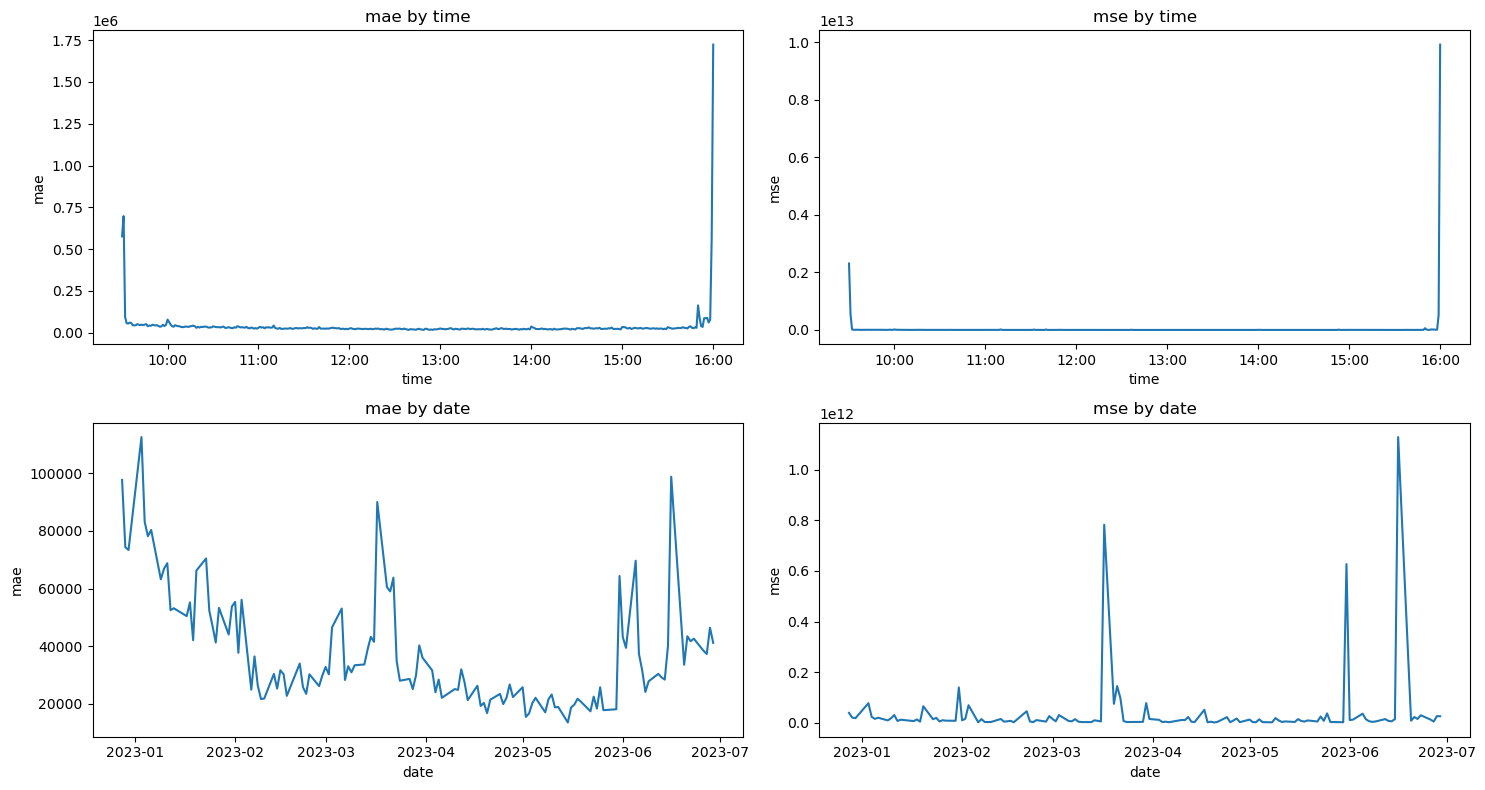

In [39]:
print('plot for train set: ')
performance_analysis(train_res)

plot for test set: 


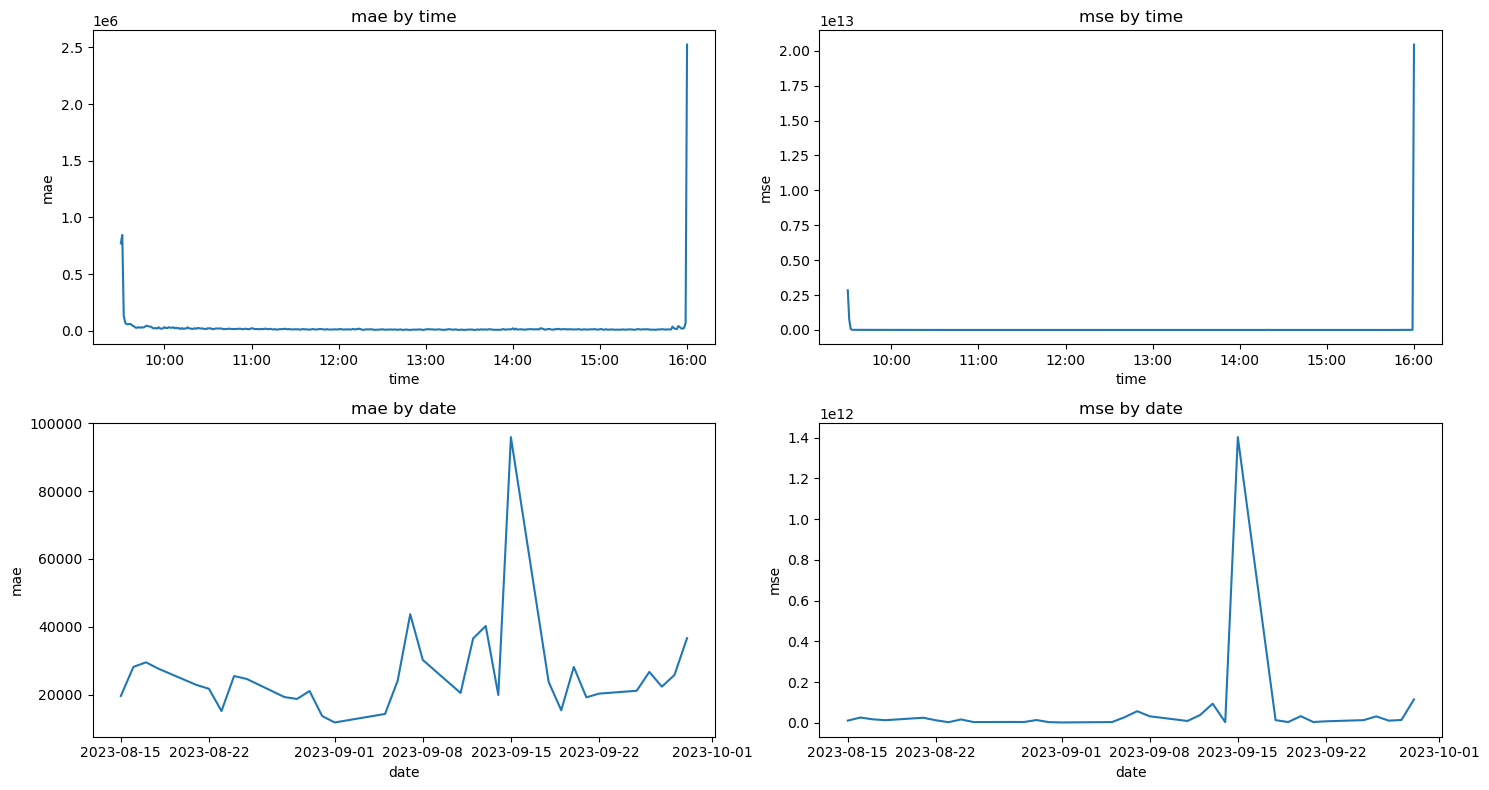

In [40]:
print('plot for test set: ')
performance_analysis(test_res)

It is obvious that most errors occur at market open and market close. One actionable improvement for this situation is to develop additional features (eg. using data from the order book) that could enhance the prediction of stock volumes, since the data and features used in this project are rather limited.